In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from dataset import IterableSpectraDataset, collate_fn
from model import SpectrumGenerator
from utils import get_config2, resolve_path
from glob import glob

In [2]:

# Function to load the configuration
def load_configurations():
    config = get_config2()
    dataset_name = config['dataset_name']
    dataset_config = config['datasets'][dataset_name]
    data_path = resolve_path(dataset_config['path'])
    checkpoints_path = resolve_path(config['paths']['checkpoints'])
    batch_size = config['training']['batch_size']
    return config, data_path, checkpoints_path, batch_size


In [3]:
# Function to prepare the dataset
def prepare_datasets(data_path, batch_size, yield_full_spectrum=True):
    dataset = IterableSpectraDataset(data_path, is_validation=False, yield_full_spectrum=yield_full_spectrum)
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    return data_loader

In [4]:
# Function to load the optimized latent codes from HDF5 file
def load_optimized_latent_codes(file_list):
    latent_codes = {}
    for file_path in file_list:
        with h5py.File(file_path, 'r') as f:
            for group_name in f.keys():
                group = f[group_name]
                if 'optimized_latent_code/latest' in group:
                    latent_codes[group_name] = torch.tensor(group['optimized_latent_code/latest'][:], dtype=torch.float32)
    return latent_codes


In [5]:
def generate_full_spectra(spectrum_generator, latent_codes, batch):
    # Decode spectrum IDs if necessary
    unique_ids = [uid.decode('utf-8') if isinstance(uid, bytes) else uid for uid in batch['spectrum_id']]
    
    # Filter valid IDs based on presence in the latent codes dictionary
    valid_ids = [uid for uid in unique_ids if uid in latent_codes]
    
    # Gather corresponding latent vectors for valid IDs
    latent_vectors = torch.stack([latent_codes[uid] for uid in valid_ids])
    
    # Ensure observed wavelengths are provided in the batch and are correctly formatted
    if 'wavelength' in batch:
        observed_wavelengths = batch['wavelength']
    else:
        raise ValueError("Observed wavelengths are required in the batch.")

    # Generate spectra using the SpectrumGenerator
    generated_spectra = spectrum_generator(latent_vectors, observed_wavelengths)
    
    return generated_spectra, valid_ids


In [18]:
def plot_spectra(batch, generated_spectra, valid_ids, num_spectra=10):
    num_plots = min(num_spectra, len(valid_ids))
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots))
    if num_plots == 1:
        axes = [axes]

    spectrum_ids = [sid.decode('utf-8') if isinstance(sid, bytes) else sid for sid in batch['spectrum_id']]

    for i in range(num_plots):
        uid = valid_ids[i]
        uid = uid.decode('utf-8') if isinstance(uid, bytes) else uid  # Ensure uid is a string

        # Debug: Print the uid and list of spectrum_ids
        print("UID:", uid)
        print("Spectrum IDs in batch:", spectrum_ids)

        try:
            index = spectrum_ids.index(uid)
            real_spectrum = batch['flux'][index].detach().cpu().numpy()
            wavelengths = batch['wavelength'][index].detach().cpu().numpy()

            # Ensure the generated spectra tensor is also detached and moved to CPU
            gen_spectrum = generated_spectra[i].detach().cpu().numpy()
            # axes[i].set_xlim(6000, 8000)
            # axes[i].set_ylim(0, 2)

            axes[i].plot(wavelengths, real_spectrum, label='Real Spectrum', color='blue', linewidth=0.5, alpha=0.7)
            axes[i].plot(wavelengths, gen_spectrum, label='Generated Spectrum', color='red', linewidth=0.5, alpha=0.7)
            axes[i].set_title(f'Spectrum ID: {uid}')
            axes[i].set_xlabel('Wavelength')
            axes[i].set_ylabel('Flux')
            axes[i].legend()
        except ValueError as e:
            print(f"Error: {e}")
            continue  # Skip this plot if the UID is not found

    plt.tight_layout()
    plt.show()


In [19]:
print("Initializing device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading configurations...")
config, data_path, checkpoints_path, batch_size = load_configurations()


Initializing device...
Using device: cpu
Loading configurations...


In [20]:
print("Preparing datasets with full spectra...")
data_loader_full_spectra = prepare_datasets(data_path, batch_size, yield_full_spectrum=True)



Preparing datasets with full spectra...


In [21]:
print("Initializing model...")
# Assuming the high-resolution wavelength grid is part of the configuration, or needs to be generated
wavelength_grid = [
    (15050, 15850, 0.2),
    (15870, 16440, 0.2),
    (16475, 17100, 0.2),
    (4700, 4930, 0.05),
    (5630, 5880, 0.05),
    (6420, 6800, 0.05),
    (7500, 7920, 0.05)
]
high_res_wavelength_grid = torch.cat([torch.arange(start, end + step, step) for start, end, step in wavelength_grid])

# Initialize the SpectrumGenerator with the necessary configuration parameters
spectrum_generator = SpectrumGenerator(
    latent_dim=config['training']['latent_dim'],
    output_dim=high_res_wavelength_grid.shape[0],  # Assuming output_dim should match the size of the wavelength grid
    layers=config['model']['generator_layers'],
    activation_function=config['model']['activation_function']
).to(device)

# Load the best checkpoint
checkpoint_path = os.path.join(checkpoints_path, 'checkpoint_best.pth.tar')
checkpoint = torch.load(checkpoint_path, map_location=device)  # Ensure it's loaded to the correct device
spectrum_generator.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
spectrum_generator.eval()

print("Model initialized and checkpoint loaded.")


Initializing model...
Initializing Generator.
Initialized weights for Linear with shape: torch.Size([24, 20])
No weights to initialize for LeakyReLU
Initialized weights for Linear with shape: torch.Size([256, 24])
No weights to initialize for LeakyReLU
Initialized weights for Linear with shape: torch.Size([256, 256])
No weights to initialize for LeakyReLU
Initialized weights for Linear with shape: torch.Size([35589, 256])
No weights to initialize for Sequential
No weights to initialize for Generator
Generator initialized with final output dimension: 35589
High-res wavelength shape: torch.Size([35589])
Model initialized and checkpoint loaded.


In [22]:
print("Loading optimized latent codes...")
file_list = glob(os.path.join(data_path, 'spectra_healpix_*.hdf5'))
latent_codes = load_optimized_latent_codes(file_list)


Loading optimized latent codes...


UID: 41_apogee_124
Spectrum IDs in batch: ['41_apogee_124', '41_apogee_265', '146_galah_356', '30_apogee_107', '30_apogee_209', '30_apogee_213', '123_galah_370', '75_galah_313']
UID: 41_apogee_265
Spectrum IDs in batch: ['41_apogee_124', '41_apogee_265', '146_galah_356', '30_apogee_107', '30_apogee_209', '30_apogee_213', '123_galah_370', '75_galah_313']
UID: 146_galah_356
Spectrum IDs in batch: ['41_apogee_124', '41_apogee_265', '146_galah_356', '30_apogee_107', '30_apogee_209', '30_apogee_213', '123_galah_370', '75_galah_313']
UID: 30_apogee_107
Spectrum IDs in batch: ['41_apogee_124', '41_apogee_265', '146_galah_356', '30_apogee_107', '30_apogee_209', '30_apogee_213', '123_galah_370', '75_galah_313']
UID: 30_apogee_209
Spectrum IDs in batch: ['41_apogee_124', '41_apogee_265', '146_galah_356', '30_apogee_107', '30_apogee_209', '30_apogee_213', '123_galah_370', '75_galah_313']
UID: 30_apogee_213
Spectrum IDs in batch: ['41_apogee_124', '41_apogee_265', '146_galah_356', '30_apogee_107',

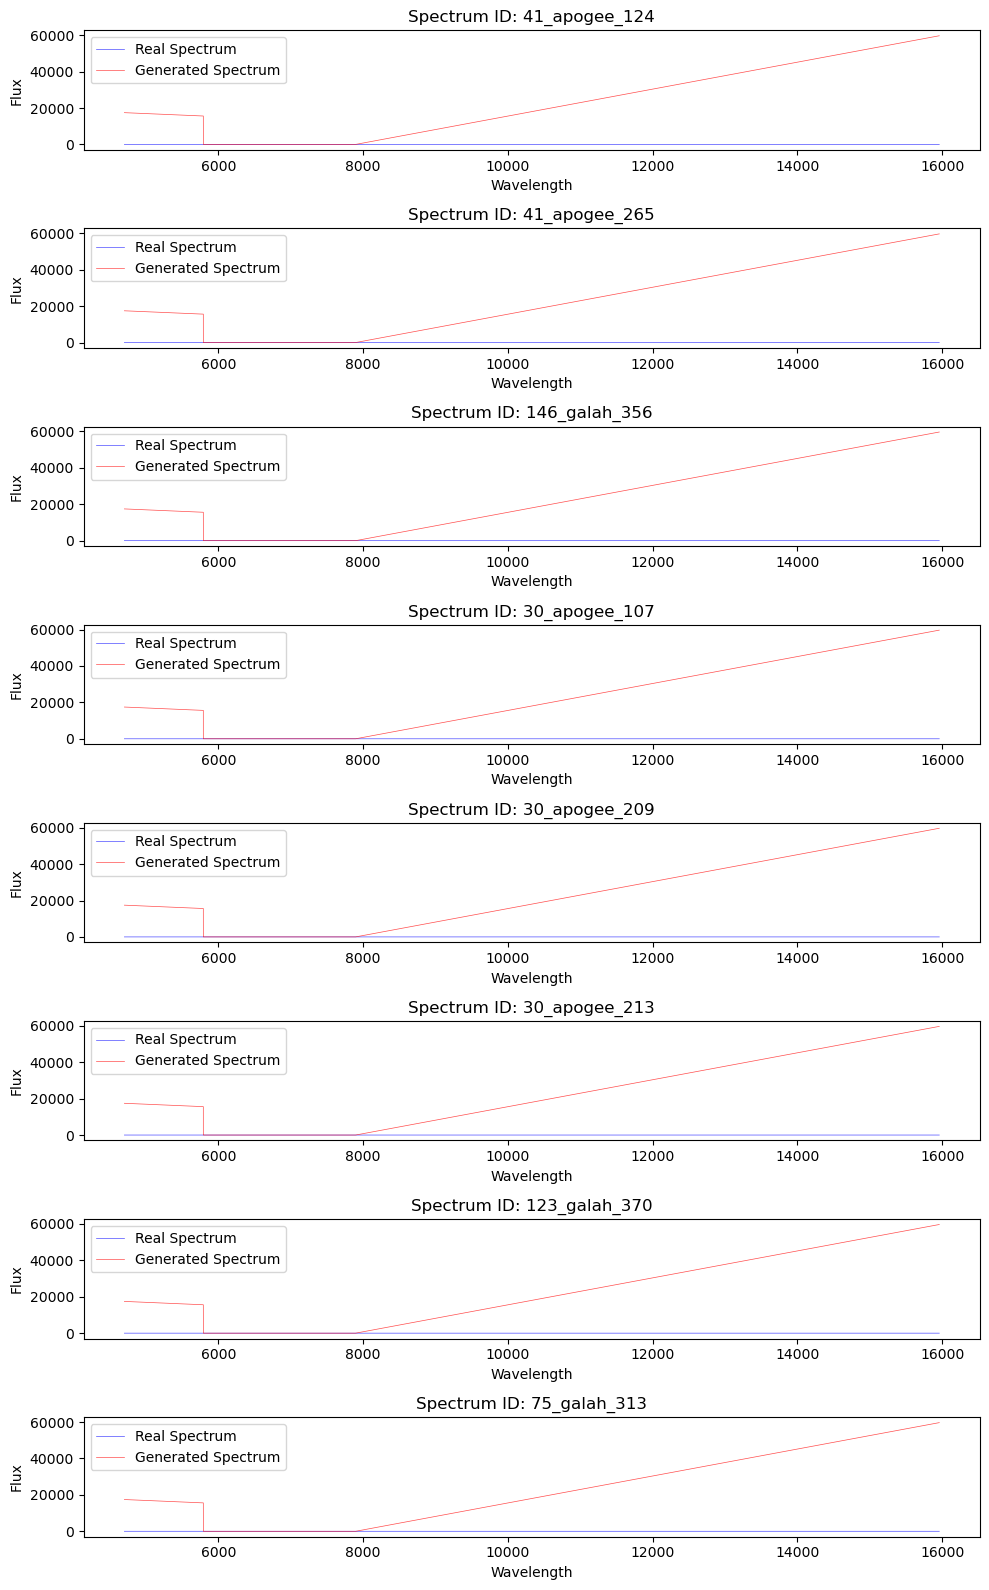

In [23]:
for batch in data_loader_full_spectra:
    generated_spectra, valid_ids = generate_full_spectra(spectrum_generator, latent_codes, batch)
    plot_spectra(batch, generated_spectra, valid_ids, num_spectra=10)
    break  # Only process the first batch